In [35]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 14a

## Sequential Model using ionosphere putting it together

1. Monitor validation set as well as training set
2. L2 Regularization
3. Dropouts
4. Batch Norm
5. Early stopping

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [36]:
# Lets import some libraries
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf

# from utils.helper import fn_plot_tf_hist

%matplotlib inline

In [37]:
# Some basic parameters

inpDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day9/input' # location where input data is stored
outDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day9/output' # location to store outputs
modelDir = '/home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day9/models'
subDir = 'ionosphere'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
 
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 100         # number of epochs
ALPHA = 0.001        # learning rate
WEIGHT_DECAY = 0.001 # Weight decay
BATCH_SIZE = 16      # other sizes leave last batch partial

TRAIN_SIZE = int(BATCH_SIZE*18)

PATIENCE = 20
LR_PATIENCE = 5
LR_FACTOR = 0.1

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

In [38]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


In [39]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load Data

### Data Set Information:

This radar data was collected by a system in Goose Bay, Labrador. This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts. See the paper for more details. The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere. "Bad" returns are those that do not; their signals pass through the ionosphere.

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number. There were 17 pulse numbers for the Goose Bay system. Instances in this database are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

Attribute Information:

-- All 34 are continuous
-- The 35th attribute is either "good" or "bad" according to the definition summarized above. This is a binary classification task.

We will model this as two class.

In [40]:
data_df = pd.read_csv(os.path.join(inpDir, subDir, 'ionosphere.data'), header = None)
data_df.shape

(351, 35)

In [41]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [42]:
X = data_df.drop(data_df.columns[-1], axis = 1).to_numpy()

y = data_df[data_df.columns[-1]].to_numpy()

In [43]:
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                   train_size = TRAIN_SIZE,
                                                   stratify=y,
                                                   random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((288, 34), (63, 34), (288,), (63,))

In [44]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)

y_test = le.transform(y_test)

In [45]:
class_name = list(le.classes_)
class_name

['b', 'g']

In [46]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [47]:
## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model1 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dense (18,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),

   tf.keras.layers.Dense (10,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dense (2),
    
])

In [48]:
model1.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])



In [49]:
histroy = model1.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

Epoch 1/100
18/18 - 1s - loss: 0.5535 - accuracy: 0.7535 - val_loss: 0.5141 - val_accuracy: 0.7619 - 861ms/epoch - 48ms/step
Epoch 2/100
18/18 - 0s - loss: 0.4384 - accuracy: 0.8576 - val_loss: 0.4455 - val_accuracy: 0.8095 - 104ms/epoch - 6ms/step
Epoch 3/100
18/18 - 0s - loss: 0.3698 - accuracy: 0.8750 - val_loss: 0.3882 - val_accuracy: 0.8413 - 64ms/epoch - 4ms/step
Epoch 4/100
18/18 - 0s - loss: 0.3163 - accuracy: 0.8993 - val_loss: 0.3509 - val_accuracy: 0.8413 - 91ms/epoch - 5ms/step
Epoch 5/100
18/18 - 0s - loss: 0.2757 - accuracy: 0.9028 - val_loss: 0.3248 - val_accuracy: 0.8571 - 70ms/epoch - 4ms/step
Epoch 6/100
18/18 - 0s - loss: 0.2423 - accuracy: 0.9201 - val_loss: 0.2995 - val_accuracy: 0.8571 - 75ms/epoch - 4ms/step
Epoch 7/100
18/18 - 0s - loss: 0.2128 - accuracy: 0.9271 - val_loss: 0.2803 - val_accuracy: 0.8571 - 80ms/epoch - 4ms/step
Epoch 8/100
18/18 - 0s - loss: 0.1886 - accuracy: 0.9375 - val_loss: 0.2631 - val_accuracy: 0.8571 - 87ms/epoch - 5ms/step
Epoch 9/100
1

In [50]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 26)                910       
                                                                 
 dense_9 (Dense)             (None, 18)                486       
                                                                 
 dense_10 (Dense)            (None, 10)                190       
                                                                 
 dense_11 (Dense)            (None, 2)                 22        
                                                                 
Total params: 1608 (6.28 KB)
Trainable params: 1608 (6.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
hist_df = pd.DataFrame(histroy.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.553530,0.753472,0.514139,0.761905
1,0.438369,0.857639,0.445451,0.809524
2,0.369782,0.875000,0.388246,0.841270
3,0.316250,0.899306,0.350870,0.841270
4,0.275735,0.902778,0.324768,0.857143


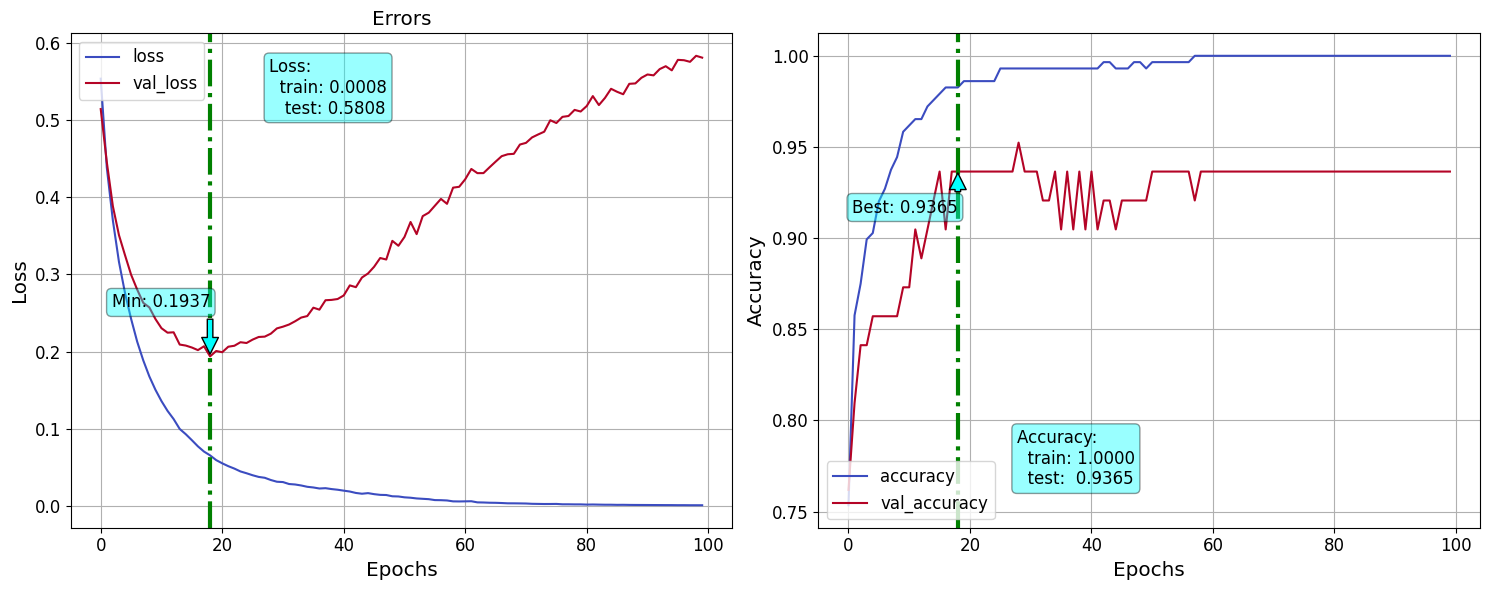

In [52]:
fn_plot_tf_hist(hist_df)

In [53]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
18,0.065481,0.982639,0.193683,0.936508


In [54]:
proba_model1 = tf.keras.Sequential([model1,
                                   tf.keras.layers.Softmax()])

y_pred = proba_model1(X_test)

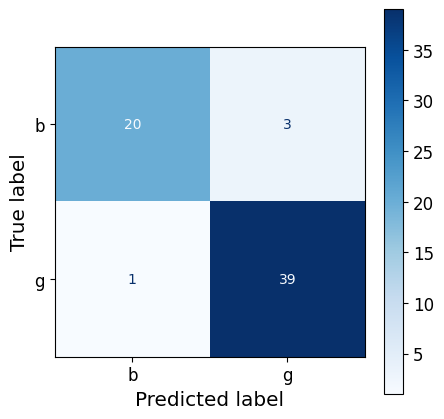

In [55]:
cm = confusion_matrix(y_test, y_pred.numpy().argmax(axis = 1) )

disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=class_name)

fig, ax = plt.subplots(figsize=(5,5))

disp.plot(ax = ax, cmap = plt.cm.Blues);

## L2 Regularizer

In [56]:
## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

regularizer = tf.keras.regularizers.L2(0.05)

model2 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =( 34, ) ),

    tf.keras.layers.Dense (26,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),   # ---- add L2 Regularizer
    
    tf.keras.layers.Dense (18,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),   # ---- add L2 Regularizer

   tf.keras.layers.Dense (10,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),   # ---- add L2 Regularizer
    
    tf.keras.layers.Dense (2),
    
])

model2.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])


history = model2.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/100
18/18 - 1s - loss: 3.5576 - accuracy: 0.6389 - val_loss: 3.3436 - val_accuracy: 0.6032 - 877ms/epoch - 49ms/step
Epoch 2/100
18/18 - 0s - loss: 3.1579 - accuracy: 0.7500 - val_loss: 2.9779 - val_accuracy: 0.7302 - 81ms/epoch - 4ms/step
Epoch 3/100
18/18 - 0s - loss: 2.8072 - accuracy: 0.8403 - val_loss: 2.6561 - val_accuracy: 0.8095 - 89ms/epoch - 5ms/step
Epoch 4/100
18/18 - 0s - loss: 2.5033 - accuracy: 0.8507 - val_loss: 2.3737 - val_accuracy: 0.8730 - 103ms/epoch - 6ms/step
Epoch 5/100
18/18 - 0s - loss: 2.2361 - accuracy: 0.8611 - val_loss: 2.1266 - val_accuracy: 0.8889 - 90ms/epoch - 5ms/step
Epoch 6/100
18/18 - 0s - loss: 2.0033 - accuracy: 0.8611 - val_loss: 1.9096 - val_accuracy: 0.8730 - 86ms/epoch - 5ms/step
Epoch 7/100
18/18 - 0s - loss: 1.7968 - accuracy: 0.8785 - val_loss: 1.7192 - val_accuracy: 0.8730 - 99ms/epoch - 6ms/step
Epoch 8/100
18/18 - 0s - loss: 1.6151 - accuracy: 0.8819 - val_loss: 1.5506 - val_accuracy: 0.8730 - 80ms/epoch - 4ms/step
Epoch 9/100
1

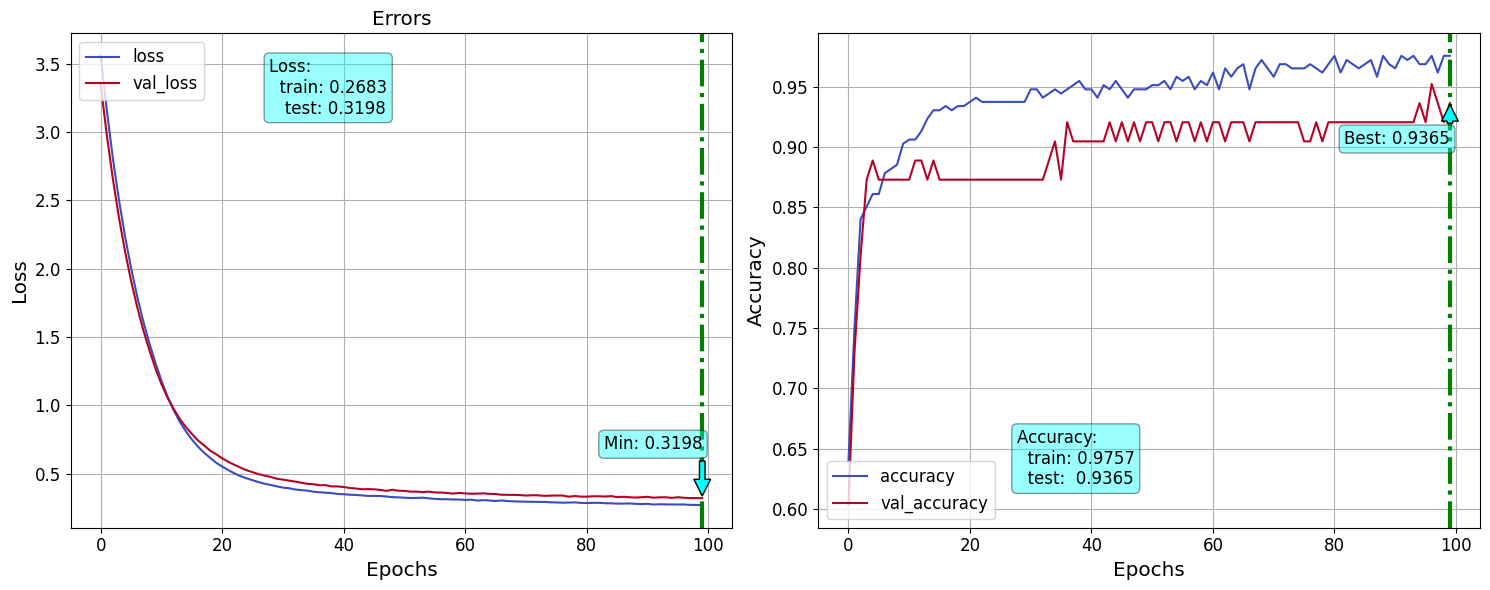

In [57]:
fn_plot_tf_hist(hist_df)

## Batch Normalization

In [58]:
## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model3 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    
    tf.keras.layers.Dense (18,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    tf.keras.layers.Dense (10,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    tf.keras.layers.Dense (2),
    
])


model3.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])


history = model3.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/100
18/18 - 2s - loss: 0.6930 - accuracy: 0.6771 - val_loss: 0.7536 - val_accuracy: 0.6349 - 2s/epoch - 87ms/step
Epoch 2/100
18/18 - 0s - loss: 0.5995 - accuracy: 0.7153 - val_loss: 0.6725 - val_accuracy: 0.7143 - 92ms/epoch - 5ms/step
Epoch 3/100
18/18 - 0s - loss: 0.5440 - accuracy: 0.7535 - val_loss: 0.5984 - val_accuracy: 0.7460 - 95ms/epoch - 5ms/step
Epoch 4/100
18/18 - 0s - loss: 0.4942 - accuracy: 0.7812 - val_loss: 0.5403 - val_accuracy: 0.8095 - 125ms/epoch - 7ms/step
Epoch 5/100
18/18 - 0s - loss: 0.4558 - accuracy: 0.8160 - val_loss: 0.4889 - val_accuracy: 0.8571 - 128ms/epoch - 7ms/step
Epoch 6/100
18/18 - 0s - loss: 0.4030 - accuracy: 0.8403 - val_loss: 0.4343 - val_accuracy: 0.8889 - 113ms/epoch - 6ms/step
Epoch 7/100
18/18 - 0s - loss: 0.3949 - accuracy: 0.8576 - val_loss: 0.3875 - val_accuracy: 0.9206 - 113ms/epoch - 6ms/step
Epoch 8/100
18/18 - 0s - loss: 0.3765 - accuracy: 0.8368 - val_loss: 0.3472 - val_accuracy: 0.9365 - 101ms/epoch - 6ms/step
Epoch 9/100


In [59]:
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.693015,0.677083,0.753618,0.634921
1,0.599482,0.715278,0.672489,0.714286
2,0.544011,0.753472,0.598393,0.746032
3,0.494188,0.781250,0.540312,0.809524
4,0.455786,0.815972,0.488859,0.857143
...,...,...,...,...
95,0.088518,0.972222,0.110888,0.936508
96,0.043260,0.982639,0.120520,0.920635
97,0.105117,0.968750,0.114372,0.920635
98,0.066360,0.979167,0.094652,0.952381


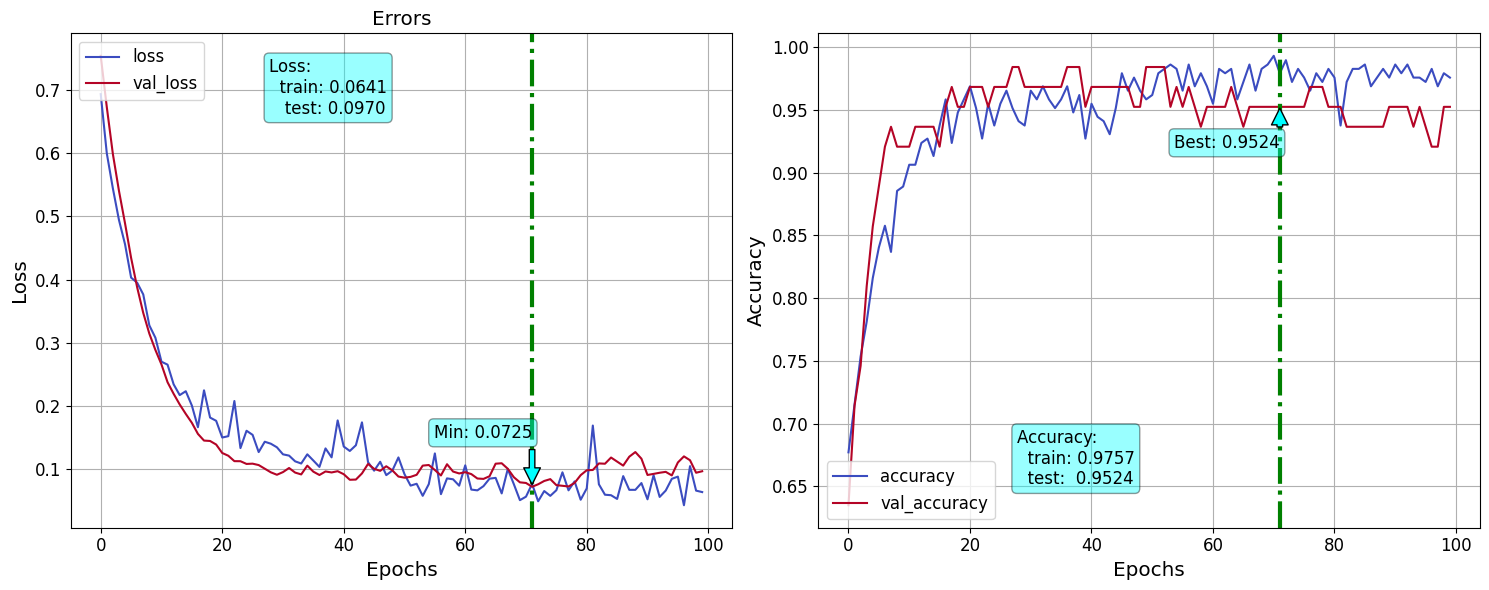

In [60]:
fn_plot_tf_hist(hist_df)

In [61]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
71,0.076937,0.979167,0.072487,0.952381


## DROP OUTS

In [62]:
rate1 = 0.2
rate2 = 0.3
rate3 = 0.4

## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model4 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           activation = 'relu',
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dropout(rate1 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (18,
                           activation = 'relu',
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dropout(rate2 , seed = RANDOM_STATE),

    tf.keras.layers.Dense (10,
                           activation = 'relu',
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dropout(rate3 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (2),
    
])


model4.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])


history = model4.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/100
18/18 - 1s - loss: 0.9137 - accuracy: 0.5938 - val_loss: 0.8471 - val_accuracy: 0.6032 - 958ms/epoch - 53ms/step
Epoch 2/100
18/18 - 0s - loss: 0.8140 - accuracy: 0.6007 - val_loss: 0.7504 - val_accuracy: 0.6032 - 86ms/epoch - 5ms/step
Epoch 3/100
18/18 - 0s - loss: 0.6959 - accuracy: 0.6562 - val_loss: 0.6835 - val_accuracy: 0.6190 - 86ms/epoch - 5ms/step
Epoch 4/100
18/18 - 0s - loss: 0.6516 - accuracy: 0.6493 - val_loss: 0.6154 - val_accuracy: 0.6667 - 88ms/epoch - 5ms/step
Epoch 5/100
18/18 - 0s - loss: 0.6533 - accuracy: 0.6771 - val_loss: 0.5693 - val_accuracy: 0.7460 - 98ms/epoch - 5ms/step
Epoch 6/100
18/18 - 0s - loss: 0.5906 - accuracy: 0.7083 - val_loss: 0.5320 - val_accuracy: 0.7460 - 102ms/epoch - 6ms/step
Epoch 7/100
18/18 - 0s - loss: 0.5830 - accuracy: 0.7188 - val_loss: 0.5058 - val_accuracy: 0.7460 - 102ms/epoch - 6ms/step
Epoch 8/100
18/18 - 0s - loss: 0.5296 - accuracy: 0.7500 - val_loss: 0.4898 - val_accuracy: 0.7460 - 91ms/epoch - 5ms/step
Epoch 9/100


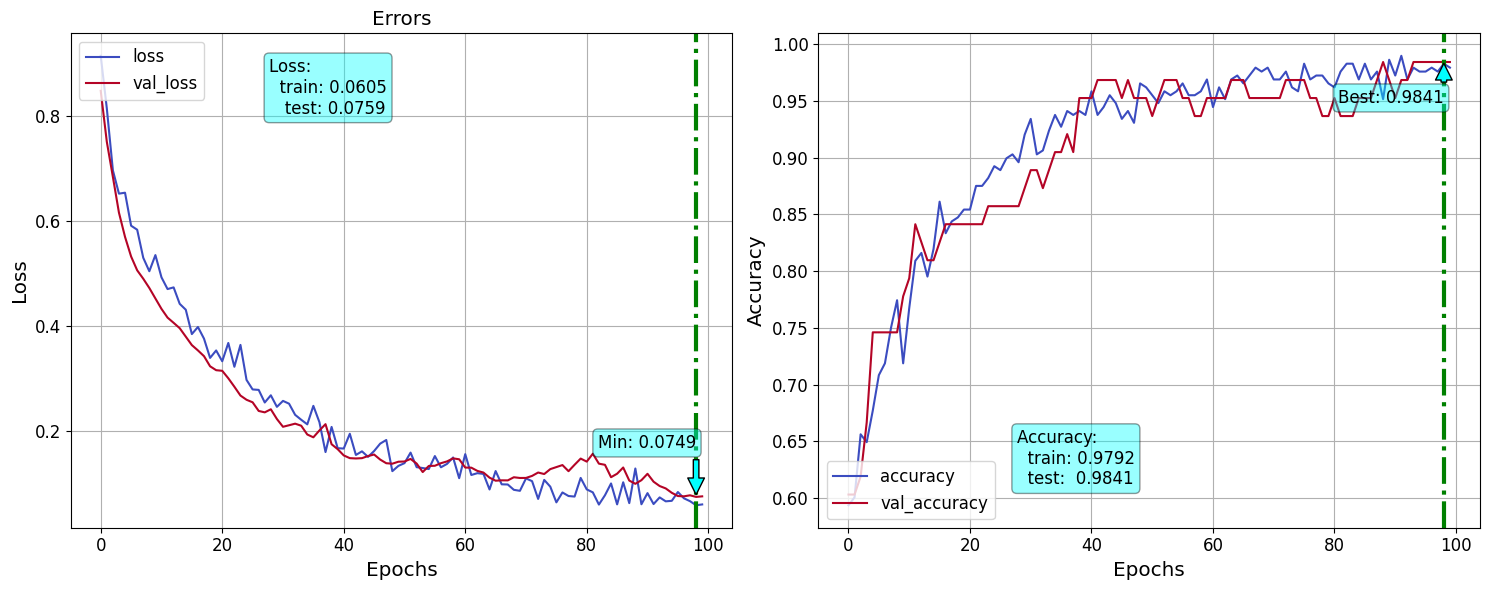

In [63]:
fn_plot_tf_hist(hist_df)

In [64]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
98,0.058999,0.982639,0.074865,0.984127


### All In

In [65]:
rate1 = 0.05
rate2 = 0.05
rate3 = 0.05

## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.AdamW(learning_rate=ALPHA, weight_decay=WEIGHT_DECAY) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

# Suppressing regularization
#regularizer = tf.keras.regularizers.L2(0.05)
regularizer = None

model = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate1 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (18,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate2 , seed = RANDOM_STATE),

    tf.keras.layers.Dense (10,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate3 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (2),
    
])

model.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])

In [66]:
checkpoint_filepath = os.path.join(modelDir, subDir, 'weights_all_in')

chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = 'val_loss',
    mode = 'auto',
    verbose = 2,
    save_best_only = True
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    verbose = 2,
    baseline =None,
    restore_best_weights=True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_lr=0.00001)

In [67]:
history = model.fit( x = X_train, 
                     y = y_train,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2,
                    callbacks = [es_callback, chkpt_callback, lr_callback])

hist_df = pd.DataFrame(history.history)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.62097, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day9/models/ionosphere/weights_all_in
18/18 - 2s - loss: 0.7070 - accuracy: 0.6146 - val_loss: 0.6210 - val_accuracy: 0.5714 - lr: 0.0010 - 2s/epoch - 108ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.62097 to 0.52728, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day9/models/ionosphere/weights_all_in
18/18 - 0s - loss: 0.5318 - accuracy: 0.7465 - val_loss: 0.5273 - val_accuracy: 0.9048 - lr: 0.0010 - 119ms/epoch - 7ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.52728 to 0.45321, saving model to /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day9/models/ionosphere/weights_all_in
18/18 - 0s - loss: 0.4396 - accuracy: 0.8507 - val_loss: 0.4532 - val_accuracy: 0.9365 - lr: 0.0010 - 135ms/epoch - 7ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.45321 to 0.39311, saving model 

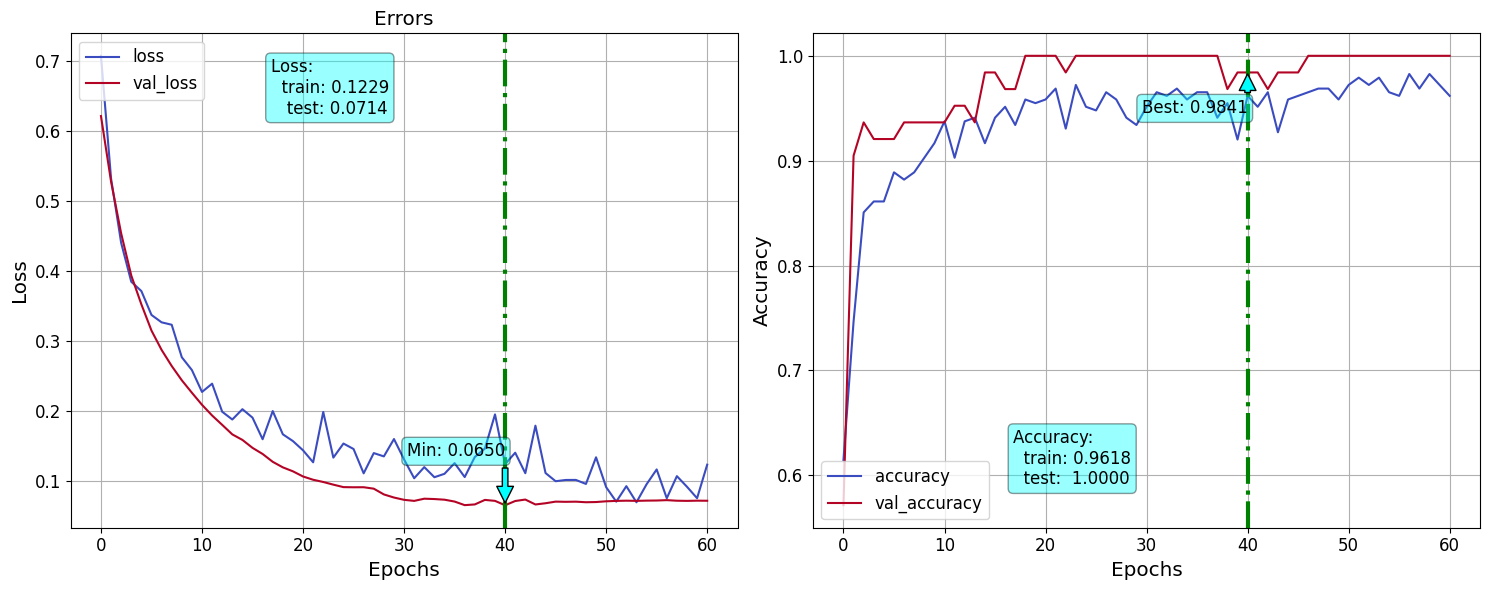

In [68]:
fn_plot_tf_hist(hist_df)

In [69]:
loss_dict = model.evaluate(X_test, y_test, verbose=1 , return_dict=True)

2/2 [==============================] - 0s 5ms/step - loss: 0.0650 - accuracy: 0.9841


In [70]:
loss_dict

{'loss': 0.06497281789779663, 'accuracy': 0.9841269850730896}

In [71]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy,lr
40,0.123781,0.961806,0.064973,0.984127,0.001


In [72]:
del model
del model1
del model2
del model3
del model4

In [73]:
## Some model functions

initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA) # using Adam optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

rate = 0.2

model = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34,)  ),
    
    tf.keras.layers.Dense (26,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate1 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (18,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate2 , seed = RANDOM_STATE),

    tf.keras.layers.Dense (10,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation(activation='relu'),

    #tf.keras.layers.Dropout(rate3 , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (2),
    
])

model.compile(optimizer=optimizer,
               loss = loss_fn,
               metrics= ['accuracy'])

In [74]:
res = model.evaluate(X_test, y_test, verbose=2, return_dict=True)

res['accuracy']

2/2 - 0s - loss: 0.8734 - accuracy: 0.3651 - 260ms/epoch - 130ms/step


0.3650793731212616

In [75]:
model.load_weights(checkpoint_filepath)

In [76]:
res = model.evaluate(X_test, y_test, verbose=2, return_dict=True)

res['accuracy']

2/2 - 0s - loss: 0.0650 - accuracy: 0.9841 - 25ms/epoch - 13ms/step


0.9841269850730896

## Save Complete Model

In [77]:
model_path = os.path.join(modelDir, subDir, 'complete_all_in')

tf.keras.models.save_model(model, model_path)

INFO:tensorflow:Assets written to: /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day9/models/ionosphere/complete_all_in/assets


INFO:tensorflow:Assets written to: /home/pgdai/Desktop/March24-DAI-Workspace/DNN-May24/LectureStuff/Day9/models/ionosphere/complete_all_in/assets


In [78]:
model1 = tf.keras.models.load_model(model_path)

In [79]:
res = model1.evaluate(X_test, y_test, verbose=2, return_dict=True)

res['accuracy']

2/2 - 0s - loss: 0.0650 - accuracy: 0.9841 - 162ms/epoch - 81ms/step


0.9841269850730896

In [80]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 26)                910       
                                                                 
 batch_normalization_9 (Bat  (None, 26)                104       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 26)                0         
                                                                 
 dense_29 (Dense)            (None, 18)                486       
                                                                 
 batch_normalization_10 (Ba  (None, 18)                72        
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 18)               